<a href="https://colab.research.google.com/github/Epilef86/DNC/blob/main/Clusteriza%C3%A7%C3%A3o_Gaussian_Mixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

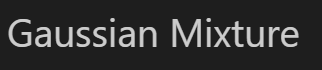

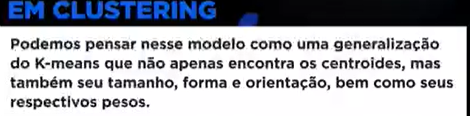

Características:

1- Requer dados numéricos contínuos na mesma escala;
2- Requer a especificação da quantidade de grupos (K);
3- Avaliação se dá por BIC (bayesian information criterion), que nada mais é do que uma análise estatistica pra comparar modelos de regressão

Vantagens:

1- modelo bem mais recente que os demais, então está em constante aprimoramente;
2- capaz de identificar clusters sobrepostos;
3- cada observação pode ser descrita com a sua probabilidade

Desvantagens:

1- possui suposições que afetam o modelo;
2- não escalável para grande volume de dados

Modelo diferente dos demais, é um modelo probabilistico, não é baseado em densidade nem em centróide. Apesar de que tem um aspecto parecido com KMeans.

As observações são geradas a partir de um mix de distribuições gaussianas, que nada mais é do que distribuições normais. Pra entender a fundo os conceitos, é necessário entender de probabilidade probabilistica

No círculo azul temos as observações, cada ponto do gráfico, cada linha da tabela. O que vai influenciar em qual cluster essa observação se encontra é a media do centróide e uma matriz de covariância de cada feature (coluna) que tem no modelo. A bola branca temos os clusters que são pré-definidos pelo usuário e cada clusters tera um peso diferente. Não precisamos nos preoculpar com isso pois todos os pesos, médias..etc, vão ser estimadas pelo modelo. Esse conjunto de atributos é que vai influenciar o modelo, dizer qual observação pertence a qual cluster, é mais especificamente um modelo probabilistico então será a probabilidade de tal amostra pertencer a tal cluster 

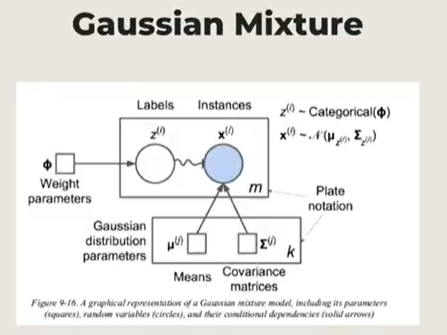

In [2]:
# Data wrangling
import numpy as np
import pandas as pd

# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

## -- Machine learning -- ##
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Didatic purposes
import string
from ipywidgets import interact

In [3]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

In [4]:
# Simulate clusters
X,y = datasets.make_blobs(n_samples=int(1E3), n_features=2, centers=4, cluster_std=.8, random_state=0)
df = pd.DataFrame(X, columns=list(string.ascii_uppercase[:X.shape[1]]))
df.head()

,A,B
0,-2.256086,7.858356
1,0.568548,3.953328
2,-2.602152,8.418937
3,-2.625338,2.063689
4,2.286564,1.227960


Criando modelo: precisamos das quantidade de componentes, tipo de covariância, tolerânci pra convergência quantidade máxima de interação e inicializações que vão ser realizadas. Por default está 1.

In [5]:
# Create model
model = GaussianMixture(n_components=4, covariance_type='spherical')
model.fit(X)

GaussianMixture(covariance_type='spherical', n_components=4)

Os atributos são as informações necessárias para que o algoritmo posso atribuir uma informação ao clusters, que vai ser as médias que são os centróides, covarâncias, para cada clusters e os pesos pra cada cluster.

In [6]:
# Model attributes
model.means_
model.covariances_
model.weights_

array([0.24971796, 0.24923426, 0.24989313, 0.25115465])

Pra avaliar o modelo usamos o bic, o que performa melhor é o que tem menos valor de bic.

In [7]:
# Model BIC
model.bic(X)

7426.472534059462

Pegar as labels

In [8]:
# Predict labels
model.predict(X)[:5]

array([2, 3, 2, 1, 0])

Qual a probablidade que essas observações perteçam a um cluster

In [9]:
# Predict labels' probability
model.predict_proba(X)[:5]

array([[1.90800124e-24, 2.26477374e-09, 9.99999957e-01, 4.09781975e-08],
       [8.48683486e-05, 1.66155677e-02, 3.04349256e-07, 9.83299260e-01],
       [4.44710101e-28, 2.56843817e-11, 9.99999999e-01, 5.92986506e-10],
       [3.67403383e-08, 9.99992521e-01, 1.73471302e-12, 7.44183976e-06],
       [9.99793539e-01, 9.95477687e-07, 1.01389106e-20, 2.05465177e-04]])

model.means_.T --> São os centróides, a primeira coluna são os valores de x e segunda os valores de y

In [10]:
model.means_.T

array([[ 1.99506403, -1.46742953, -1.28870348,  0.91559017],
       [ 0.85900317,  2.91770509,  7.85166035,  4.2710942 ]])

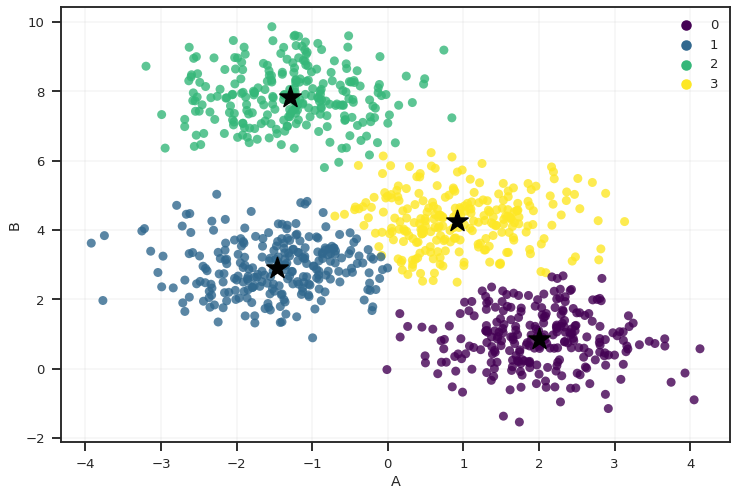

In [11]:
# Plot
labels = model.predict(X)
ax = sns.scatterplot(data=df, x='A', y='B', hue=labels, **scatter_kwargs)
ax.scatter(*model.means_.T, marker='*', color='black', s=500);

Iniciando uma lista vazia. A quantidade de k de 1 a 8, os tipos de covariância. Pra cada tipo compontente de 1 a 8 e pra cada tipo de covariancia, vou cria um modelo com a quantidade de cluster e tipo de covariancia  e os resultados vai dar um append e passar pra um dataframe.

In [12]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results

,bic,n_components,covariance_type
0,8357.218909,1,full
1,8357.218909,1,tied
2,8679.299153,1,diag
3,8889.310673,1,spherical
4,7976.527656,2,full
5,8165.511057,2,tied
6,8050.082533,2,diag
7,8036.917677,2,spherical
8,7526.427331,3,full
9,7736.187733,3,tied


Os primeiros que são os menores são os melhores

In [13]:
results.sort_values('bic').head()

,bic,n_components,covariance_type
13,7419.260293,4,tied
15,7426.425803,4,spherical
17,7442.842241,5,tied
14,7450.139988,4,diag
19,7450.422134,5,spherical


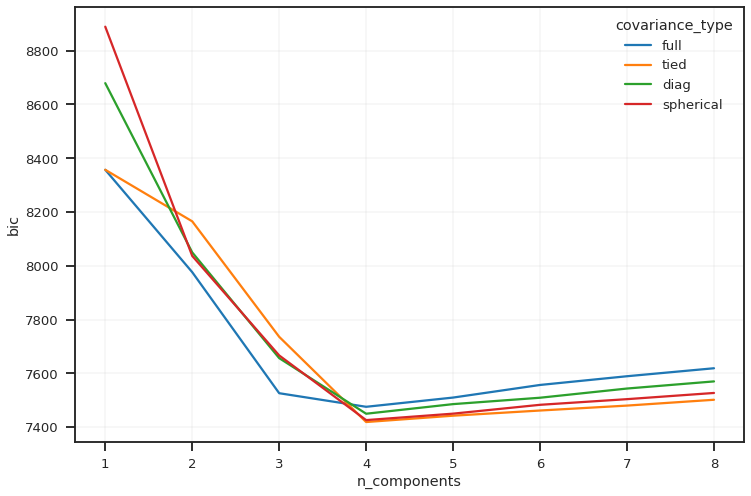

In [14]:
# Plot
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');

O gráfico representa a performance do modelo para os parâmetros em cada um tipo de covariância. Vemos que em geral cairam melhor em 4, que é o esperando uma vez que esse dados foram simulados com 4 clusters. O sheprical e tied foram os que performaram melhor, por padrão é o full.